#RBM Versus ORBM#


###Context###

In this experiement I want to objectively try and find a minimal scenario where the ORBM can do something and RBM of equivalent dimensionality can't. Where by equivalent dimentionality I mean an equivalent number of hidden nodes in total between the ORBM and RBM. 

Both the RBM and ORBM are generative models, meaning I can compare their dreams and see if they perform better or worse generatively. More objectively, I can look at the dreams and see how closely they compare to elements in the training set - In the context of an image this would be slightly difficult as I would need to compare a given dream to all elements in the training set and find the one with the least pixel-wise difference. That difference gets totalled over all dreams and I get a measure of 'badness'. Whereas if I were creating reconstructions from the training set I could examine an approximation of the log-likely of generating the training set.

$$  dream badness = \sum_k ( v_{k}' - v_{closest} )   $$

This is awkward to deal with, however I can avoid it in the in the sense that the dataset is only binary and therefore can use a bit mask (? can I? pretty sure that fact that my input is binary and has an obvious shape makes it easy) or something to decide if it is a 'good dream' or not. Dreams give a good way to measure the model captured by the system, if the model can make reconstructions akin to that of the training data then it's internal representation can't be that good.

I should clarify when I say model I am often referring to the new technique of sampling, while the model is really just the trained weight matrix in the context of dreams I really mean the technique in which we sample those weights, or collection of weights as is the case in the ORBM.

###Test###

The test I want to perform is an atomic case where the RBM is outperformed drastically by the ORBM. The test will proceed as follows:

- First a Traditional RBM will be trained to recognise a single bit on in a 16 bit vector. To make it crystal clear the training set is equivalent to np.eye(16). 
- To have any certainty about how this RBM will dream as an ORBM I will create dreams (generate visible patterns) from the RBM and ensure they a representative of the dataset. This should be trivial as any case where the sum over the vector != 1, that is for reconstruction vector $x$  

$$ isCorrect =
\begin{cases} 
  \Sigma_{i}( x_i) \neq 1 & Correct \\
  else & Incorrect
\end{cases}
 $$ won't match the training set.
 
- Once confidence is gained that the RBM has learned underlying model, I can then copy it. Giving $RBM_A$ and $RBM_B$, both with equivalent weights matrices.
- With this I will create a single RBM with the total number of hidden units of $RBM_A$ and $RBM_B$ combined. Here there is a sense of similar dimensionality in the structure of the RBM  and ORBM that hopefully allows us to compare them.
- Next we set the Traditonal RBM against the parity problem - it's a pretty hard problem, goal being, to see if it can learn how to model when there are 2 bits present anywhere in $X$ bits. 
- I suspect it will struggle. And that reconstructions of the best model I can make with this traditional RBM will leave much to be desired. 
- The composite reconstructions of the ORBM however, should be spot on, because this is the problem they were almost designed for. 
  

###Hypothesis###

I suspect that the ORBM should be able to create be generations than an RBM of similar size. The ORBM better captures the causes. The interesting aspect will be finding the threshold for better performance, obviously there will be some number of bits that an RBM can properly capture despite not understanding the multiple causes.

###Results###

Todo


In [9]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import VanillaSampler, PartitionedSampler, ApproximatedSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, rbmpy.mnist, pickle, rbmpy.rbm, os, logging, rbmpy.sampler
from sklearn.linear_model import Perceptron
from sklearn.neural_network import BernoulliRBM
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rbmpy.plotter as pp
logger = logging.getLogger()
logger.setLevel(logging.INFO)


%matplotlib inline

def plot_weights(weights):
    num_hid = weights.shape[0]
    num_vis = weights.shape[1]
    
    # we want a subplot for the weights going into each hidden, that is num_hid subplots
    weights_into_h = weights.reshape(num_vis,1,num_hid)
    subplot_count = 0
    for row in range(num_vis):
        plt.subplot(row+1, 1,subplot_count+1)
        plt.imshow(weights_into_h[subplot_count], interpolation='nearest', cmap= 'binary')
        subplot_count += 1
        
    plt.show()
    
class CountingDict(dict):
    
    def lazy_set(self,key):
        if key not in self:
            self[key] = 1
        else:
            self[key] += 1
    

def key_for_visible(v):
    return "v{}".format(v)

def check_reconstructions(model,v, times = 1000):
    result_dict = CountingDict()
    v_prime = v
    for i in range(times):
        v_prime = model.gibbs(v_prime)
        result_dict.lazy_set(key_for_visible(v_prime))
    return result_dict
    
    

class WrappedRBM(object):

    def __init__(self, sampler):
        self.sampler = sampler
        
    def gibbs(self,v):
        return self.sampler.reconstruction_given_visible(v)

###Step One##

Train an RBM to have a good genrative model of a single bit being on in an x-bit visible

Training set:
------------------
[[ 1.  0.]
 [ 0.  1.]]
------------------

Weights:
[[-0.40409125 -0.40246879]
 [-0.40895576 -0.39546694]]


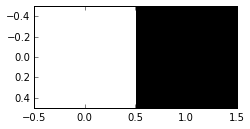

{'v[ True  True]': 86,
 'v[ True False]': 919,
 'v[False  True]': 829,
 'v[False False]': 8166}

In [4]:
# lets think about configuration, what number what I need to vary etc
rbm_n_hid = 2
orbm_n_hid = rbm_n_hid/2.0
n_vis = 2
l_rate = 0.001

training_set = np.eye(n_vis)
print("Training set:\n------------------\n{}\n------------------\n".format(training_set))

model = BernoulliRBM(n_components=rbm_n_hid,learning_rate= l_rate ,n_iter=100000)
model.fit(training_set)

print("Weights:\n{}".format(model.components_))
plot_weights(model.components_)

check_reconstructions(model, np.array([1,0]),times = 10000)

{'v[0 1]': 3641, 'v[0 0]': 29, 'v[1 0]': 6299, 'v[1 1]': 31}
Weights:
[[-6.35797244  6.69897335]
 [ 7.07205569 -6.70570051]]


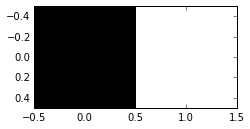

In [7]:
rbm = RBM(rbm_n_hid, n_vis,1)
sampler = VanillaSampler(rbm)
trainer = VanillaTrainier(rbm, sampler)
trainer.train(100000,training_set, learning_rate=0.005)


  
    
print(check_reconstructions(WrappedRBM(sampler), np.array([1,0]), times = 10000))
print("Weights:\n{}".format(rbm.weights))
plot_weights(rbm.weights)

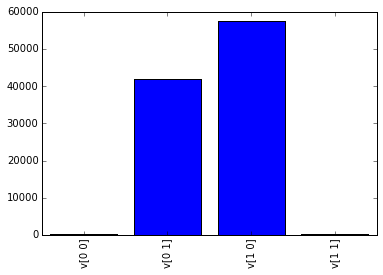

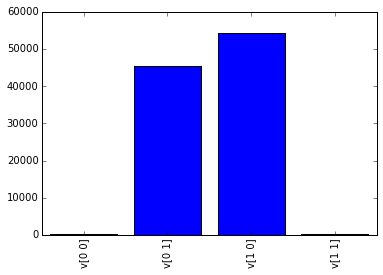

In [10]:
pp.plot_dict(check_reconstructions(WrappedRBM(sampler), np.array([0,1]), times = 100000), title = "Reconstructions Given [0,1]")
pp.plot_dict(check_reconstructions(WrappedRBM(sampler), np.array([1,0]), times = 100000), title = "Reconstructions Given [1,0]")

#Good Model Achieved#

As you can see above the reconstructions from the trained RBM do exactly what I would expect, creating good reconstructuons

In [11]:
# now I should look at the dreams and see if they are kosher
def dream(model, sampler, num_gibbs = 1000):
    current_v = np.random.randint(2, size= model.visible.shape[1])

    dream_hid = np.random.randint(2, size= model.visible.shape[1])
    for i in range(num_gibbs):
        dream_hid = sampler.visible_to_hidden(current_v)
        current_v = sampler.hidden_to_visible(dream_hid)
    return current_v

def goodnight(model, sampler, hours_of_sleep, num_gibbs_per_hour):
    result_dict = CountingDict()
    v_prime = dream(model, sampler, num_gibbs_per_hour)
    reconstruction_dict = {} # the actual reconstructions that occurred
    for i in range(hours_of_sleep):
        v_prime = dream(model, sampler, num_gibbs_per_hour)
        result_dict.lazy_set(key_for_visible(v_prime))
        reconstruction_dict[key_for_visible(v_prime)] = v_prime
    return result_dict, reconstruction_dict


In [ ]:
goodnight(rbm,sampler, 10000,1000)

#Well the model isn't perfect#

But it generates good dreams almost all of the time. It favours [1,0] which is a shame but it still has a good idea of a valid configuration. The weights are quite large aswell, all about -+7

##Time to scale it up##

I will now train and try and get similar results on a larger 1 bit pattern. Once I ahve this I can introduce a second bit. That should confuse the traditional RBM. 

In [254]:
rbm_n_hid = 20
orbm_n_hid = rbm_n_hid/2.0
n_vis = 3
training_set = np.eye(n_vis)
print("Training set:\n------------------\n{}\n------------------\n".format(training_set))

rbm = RBM(rbm_n_hid, n_vis,1)
sampler = VanillaSampler(rbm)
trainer = VanillaTrainier(rbm, sampler)
trainer.train(10000,training_set, learning_rate=0.09)

Training set:
------------------
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
------------------



In [255]:
check_reconstructions(WrappedRBM(sampler), training_set[0], times = 10000)

{'v[1 0 0]': 10000}

In [256]:
check_reconstructions(WrappedRBM(sampler), training_set[1], times = 10000)

{'v[0 1 0]': 10000}

In [257]:
check_reconstructions(WrappedRBM(sampler), training_set[2], times = 10000)

{'v[0 0 1]': 10000}

In [258]:
goodnight(rbm,sampler, 400,200)

{'v[0 0 1]': 112, 'v[0 1 0]': 189, 'v[1 0 0]': 99}

In [ ]:
goodnight(rbm,sampler, 400,100)

In [218]:
goodnight(rbm,sampler, 400,50)

{'v[0 0 1]': 275, 'v[0 1 0]': 42, 'v[0 1 1]': 1, 'v[1 0 0]': 81, 'v[1 0 1]': 1}

In [219]:
goodnight(rbm,sampler, 400,500)

{'v[0 0 1]': 348, 'v[1 0 0]': 52}

In [259]:
goodnight(rbm,sampler, 400,1000)

{'v[0 0 1]': 109, 'v[0 1 0]': 196, 'v[1 0 0]': 95}

In [4]:
class TwoModelRBM(object):
    
    def __init__(self, A, B):
        self.A = A
        self.B = B
        
    def dream_composite(self):
        a_dream = dream(self.A.rbm, sampler, num_gibbs = 100)
        b_dream = dream(self.B.rbm, sampler, num_gibbs = 100)
        h_a = self.A.visible_to_hidden(a_dream)
        h_b = self.B.visible_to_hidden(b_dream)
        psi_a = np.dot(h_a, self.A.rbm.weights)
        psi_b = np.dot(h_b, self.B.rbm.weights)
        return np.where(expit((psi_a + psi_b)) > np.random.rand(*psi_a.shape),1,0)
    
    def composite_v(self,v):
        h_a = self.A.visible_to_hidden(v)
        h_b = self.B.visible_to_hidden(v)
        psi_a = np.dot(h_a, self.A.rbm.weights)
        psi_b = np.dot(h_b, self.B.rbm.weights)
        print(psi_a)
        print(psi_b)
        print(psi_a + psi_b)
        return np.where(expit((psi_a + psi_b)) > np.random.rand(*psi_a.shape),1,0)
    

In [261]:
multi = TwoModelRBM(sampler, sampler)

In [262]:
multi.composite_v(np.array([1,1,0]))

[ -0.42621928  22.64876518 -25.27650809]
[  4.18963436  14.31047464 -20.52724243]
[  3.76341508  36.95923982 -45.80375052]


array([1, 1, 0])

In [263]:
multi.dream_composite()

array([1, 1, 0])

In [5]:
def bro_time():
    result_dict = CountingDict()
    v_prime = multi.dream_composite()
    for i in range(10000):
        v_prime =  multi.dream_composite()
        result_dict.lazy_set(key_for_visible(v_prime))
    return result_dict

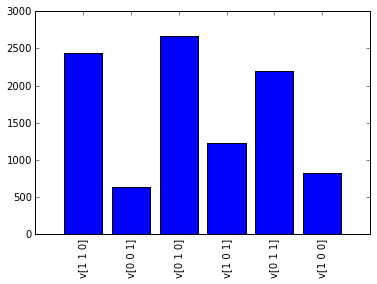

In [268]:
plotter.plot_dict(bro_time())

In [6]:
import pickle

In [7]:
# with open('newfile','wb') as f:
#     pickle.dump(rbm,f, protocol=None, fix_imports=True)
with open('newfile','rb') as f:
    three_bit_rbm = pickle.load(f)

In [78]:
def train_RBM_on_data(training_set,n_hid, l_r = 0.09):
    n_bits = training_set.shape[0]
    print("Training set:\n------------------\n{}\n------------------\n".format(training_set))
    rbm = RBM(n_hid, n_bits,1)
    sampler = VanillaSampler(rbm)
    trainer = VanillaTrainier(rbm, sampler)
    trainer.train(100000,training_set, learning_rate=l_r)
    return rbm

def check_reconstructions_for_data(rbm, data, iterations_per_item = 1000):
    # Awful, just awful
    for i in range(data.shape[0]):
        print("Expected:{}\nGot:{}".format(data[i],check_reconstructions(WrappedRBM(VanillaSampler(rbm)), data[i], times = iterations_per_item)))
        
# n_vis = 4
# training_set = np.eye(n_vis)
# yep = train_RBM_on_data(training_set,20,l_r=0.002)
# check_reconstructions_for_data(yep,training_set)

# goodnight(yep, VanillaSampler(yep),400,1000)

In [2]:
def generate_parity_problem(num_bits):
    # number of bits of the parity
    possibilities = []

    for i in range(num_bits):
        for j in range(i,num_bits):
            if i != j:
                current = np.zeros(num_bits)
                current[j] = 1
                current[i] = 1
                possibilities.append(current)
                
    return np.array(possibilities)
                

In [3]:
generate_parity_problem(4).shape

(6, 4)

In [75]:
rbm_n_hid = 10
n_vis = 3

training_set = generate_parity_problem(n_vis)
print("Training set:\n------------------\n{}\n------------------\n".format(training_set))

rbm = RBM(rbm_n_hid, n_vis,1)
sampler = VanillaSampler(rbm)
trainer = VanillaTrainier(rbm, sampler)
trainer.train(100000,training_set, learning_rate=0.009)

Training set:
------------------
[[ 1.  1.  0.]
 [ 1.  0.  1.]
 [ 0.  1.  1.]]
------------------



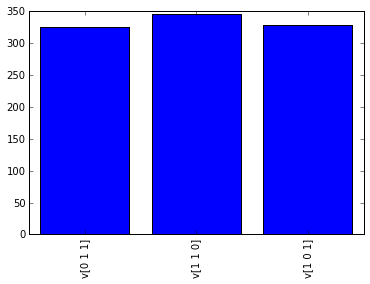

In [76]:
plotter.plot_dict(goodnight(rbm,sampler, 1000,500))

In [80]:
check_reconstructions_for_data(rbm, training_set)

Expected:[ 1.  1.  0.]
Got:{'v[1 1 0]': 994, 'v[0 1 0]': 6}
Expected:[ 1.  0.  1.]
Got:{'v[1 0 1]': 1000}
Expected:[ 0.  1.  1.]
Got:{'v[0 1 1]': 1000}


In [86]:
# with open('three_bit_parity_rbm','wb') as f:
#     pickle.dump(rbm,f, protocol=None, fix_imports=True)

In [121]:
class RBM_Performance_Recorder(object):
    
    def __init__(self,training_set):
        self.training_set = training_set
    
    def __calc_performance__(self, dream_counts,dreams):
        # two values
        # bad reconstruction score, count those reconstructions that don't exist in the training set, weighted by the number of times it occurs
        reconstruction_penalty = 0
        equal_prob_reconstruction_penalty = 0
        for dream_key in dreams:
            reconstruction_penalty += dream_counts[dream_key] * len(np.setdiff1d(dreams[dream_key], self.training_set))
            equal_prob_reconstruction_penalty += dream_counts[dream_key]
        equal_prob_reconstruction_penalty = equal_prob_reconstruction_penalty / len(dreams)
        return reconstruction_penalty + equal_prob_reconstruction_penalty
        
    def __do_train__(self,n_hid, l_r,epochs):
        n_hid = 10
        n_vis = self.training_set.shape[0]

        rbm = RBM(n_hid, n_vis,1)
        sampler = VanillaSampler(rbm)
        trainer = VanillaTrainier(rbm, sampler)
        trainer.train(epochs,self.training_set, learning_rate=l_r)
        dream_counts, dreams = goodnight_2(rbm,sampler, 5000,300)
        return self.__calc_performance__(dream_counts, dreams)
    
    def key_for_vals(self,epoch, l_r, n_hid):
        return "e:{} l_r:{} n_hid:{}".format(epoch,l_r, n_hid)
    
    def perform(self, rbm, l_r_min, l_r_max, l_r_step, n_hid_range, epoch_dict = [1000]):
        results = {}
        
        for num_epochs in epoch_dict:
            current_l_r = l_r_min
            while current_l_r < l_r_max:
                for current_n_hid in n_hid_range:
                    results[self.key_for_vals(num_epochs, current_l_r, current_n_hid)] = self.__do_train__(current_n_hid, current_l_r, num_epochs)
                current_l_r += l_r_step
        return results 
        
    

In [124]:
pr = RBM_Performance_Recorder(generate_parity_problem(3))
pr.perform(rbm, 0.001, 0.1, 0.05, range(10,40, 10), epoch_dict=[1000,5000,10000])

{'e:1000 l_r:0.001 n_hid:10': 625.0,
 'e:1000 l_r:0.001 n_hid:20': 625.0,
 'e:1000 l_r:0.001 n_hid:30': 625.0,
 'e:1000 l_r:0.051000000000000004 n_hid:10': 714.2857142857143,
 'e:1000 l_r:0.051000000000000004 n_hid:20': 714.2857142857143,
 'e:1000 l_r:0.051000000000000004 n_hid:30': 714.2857142857143,
 'e:10000 l_r:0.001 n_hid:10': 625.0,
 'e:10000 l_r:0.001 n_hid:20': 625.0,
 'e:10000 l_r:0.001 n_hid:30': 625.0,
 'e:10000 l_r:0.051000000000000004 n_hid:10': 1666.6666666666667,
 'e:10000 l_r:0.051000000000000004 n_hid:20': 1000.0,
 'e:10000 l_r:0.051000000000000004 n_hid:30': 2500.0,
 'e:5000 l_r:0.001 n_hid:10': 625.0,
 'e:5000 l_r:0.001 n_hid:20': 625.0,
 'e:5000 l_r:0.001 n_hid:30': 625.0,
 'e:5000 l_r:0.051000000000000004 n_hid:10': 714.2857142857143,
 'e:5000 l_r:0.051000000000000004 n_hid:20': 1250.0,
 'e:5000 l_r:0.051000000000000004 n_hid:30': 1000.0}

In [125]:
pr.perform(rbm, 0.001, 0.1, 0.05, range(10,40, 10), epoch_dict=[1000,5000,10000])


{'e:1000 l_r:0.001 n_hid:10': 625.0,
 'e:1000 l_r:0.001 n_hid:20': 625.0,
 'e:1000 l_r:0.001 n_hid:30': 625.0,
 'e:1000 l_r:0.051000000000000004 n_hid:10': 714.2857142857143,
 'e:1000 l_r:0.051000000000000004 n_hid:20': 714.2857142857143,
 'e:1000 l_r:0.051000000000000004 n_hid:30': 833.3333333333334,
 'e:10000 l_r:0.001 n_hid:10': 625.0,
 'e:10000 l_r:0.001 n_hid:20': 625.0,
 'e:10000 l_r:0.001 n_hid:30': 625.0,
 'e:10000 l_r:0.051000000000000004 n_hid:10': 1000.0,
 'e:10000 l_r:0.051000000000000004 n_hid:20': 1000.0,
 'e:10000 l_r:0.051000000000000004 n_hid:30': 1000.0,
 'e:5000 l_r:0.001 n_hid:10': 625.0,
 'e:5000 l_r:0.001 n_hid:20': 625.0,
 'e:5000 l_r:0.001 n_hid:30': 625.0,
 'e:5000 l_r:0.051000000000000004 n_hid:10': 1000.0,
 'e:5000 l_r:0.051000000000000004 n_hid:20': 833.3333333333334,
 'e:5000 l_r:0.051000000000000004 n_hid:30': 714.2857142857143}

In [126]:
pr.perform(rbm, 0.001, 0.1, 0.05, range(10,40, 10), epoch_dict=[1000,5000,10000])

{'e:1000 l_r:0.001 n_hid:10': 625.0,
 'e:1000 l_r:0.001 n_hid:20': 625.0,
 'e:1000 l_r:0.001 n_hid:30': 625.0,
 'e:1000 l_r:0.051000000000000004 n_hid:10': 714.2857142857143,
 'e:1000 l_r:0.051000000000000004 n_hid:20': 714.2857142857143,
 'e:1000 l_r:0.051000000000000004 n_hid:30': 714.2857142857143,
 'e:10000 l_r:0.001 n_hid:10': 625.0,
 'e:10000 l_r:0.001 n_hid:20': 625.0,
 'e:10000 l_r:0.001 n_hid:30': 625.0,
 'e:10000 l_r:0.051000000000000004 n_hid:10': 1250.0,
 'e:10000 l_r:0.051000000000000004 n_hid:20': 1666.6666666666667,
 'e:10000 l_r:0.051000000000000004 n_hid:30': 714.2857142857143,
 'e:5000 l_r:0.001 n_hid:10': 625.0,
 'e:5000 l_r:0.001 n_hid:20': 625.0,
 'e:5000 l_r:0.001 n_hid:30': 625.0,
 'e:5000 l_r:0.051000000000000004 n_hid:10': 833.3333333333334,
 'e:5000 l_r:0.051000000000000004 n_hid:20': 1250.0,
 'e:5000 l_r:0.051000000000000004 n_hid:30': 833.3333333333334}

In [127]:
pr.perform(rbm, 0.001, 0.1, 0.1, range(10,40, 10), epoch_dict=[10000])

{'e:1000 l_r:0.001 n_hid:10': 625.0,
 'e:1000 l_r:0.001 n_hid:20': 625.0,
 'e:1000 l_r:0.001 n_hid:30': 625.0,
 'e:10000 l_r:0.001 n_hid:10': 625.0,
 'e:10000 l_r:0.001 n_hid:20': 625.0,
 'e:10000 l_r:0.001 n_hid:30': 625.0,
 'e:5000 l_r:0.001 n_hid:10': 625.0,
 'e:5000 l_r:0.001 n_hid:20': 625.0,
 'e:5000 l_r:0.001 n_hid:30': 625.0}

In [128]:
pr.perform(rbm, 0.001, 0.01, 0.1, range(10,40, 10), epoch_dict=[10000])

{'e:10000 l_r:0.001 n_hid:10': 625.0,
 'e:10000 l_r:0.001 n_hid:20': 625.0,
 'e:10000 l_r:0.001 n_hid:30': 625.0}

In [129]:
pr.perform(rbm, 0.0001, 0.01, 0.1, range(10,40, 10), epoch_dict=[10000])

{'e:10000 l_r:0.0001 n_hid:10': 625.0,
 'e:10000 l_r:0.0001 n_hid:20': 625.0,
 'e:10000 l_r:0.0001 n_hid:30': 625.0}